In [1]:
import pandas as pd
import numpy as np

In [2]:
#IMPORT DATASET

# ISEAR ###############################
dataset_dir_isear = "dataset/ISEAR.csv"
df_isear = pd.read_csv(dataset_dir_isear, encoding='latin-1')

######################################

# dataset_dir = "dataset/data_train.csv"
# df = pd.read_csv(dataset_dir, encoding='latin-1')

# EMOINT ############################## 
dataset_dir_train_emoint = "dataset/EmoInt_Train.txt"
df_train_emoint = pd.read_csv(dataset_dir_train_emoint, sep="\t")

dataset_dir_test_emoint = "dataset/EmoInt_Test.txt"
df_test_emoint = pd.read_csv(dataset_dir_test_emoint, sep="\t")

dataset_dir_dev_emoint = "dataset/EmoInt_Dev.txt"
df_dev_emoint = pd.read_csv(dataset_dir_dev_emoint, sep="\t")

df_emoint = pd.concat([df_train_emoint, df_test_emoint, df_dev_emoint], ignore_index=True)

######################################

# df = df.drop_duplicates()


# df = pd.read_csv('dataset/train.txt', header =None, sep =';', names = ['Text','Emotion'], encoding='utf-8')

# df = pd.read_csv('dataset/train_2.txt', header =None, sep =';', names = ['Text','Emotion'], encoding='utf-8')

# with open('./out_train/dial.txt', encoding='utf-8') as f:
#     data = f.readlines();

# df1 = pd.DataFrame(data, columns=['Text'])

# with open('./out_train/emo.txt', encoding='utf-8') as f:
#     data = f.readlines();

# df = pd.concat([df1, pd.DataFrame(data, columns=['Emotion'])], axis=1)
# df = df.drop_duplicates()

# emotion_map = {'0\n': 'no emotion', '1\n': 'anger', '2\n': 'disgust', '3\n': 'fear', '4\n': 'happiness', '5\n': 'sadness', '6\n': 'surprise'}

# df['Emotion'] = df['Emotion'].map(emotion_map)

# df = df[df['Emotion'] != 'no emotion']

In [3]:
print(df_isear['Emotion'].value_counts())
print(df_emoint['Emotion'].value_counts())

Emotion
anger      1096
sadness    1096
disgust    1096
shame      1096
fear       1095
joy        1094
guilt      1093
Name: count, dtype: int64
Emotion
fear       2252
anger      1701
joy        1616
sadness    1533
Name: count, dtype: int64


In [4]:
#CONSTANTS
max_embedding_length = 300 #MAX EMBEDDING DIMENSION
max_sequence_length = 400 #INPUT LENGTH

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [6]:
def clean_df(df):
    # Remove username
    df['Text'] = df['Text'].apply(lambda x: re.sub('@[^\s]+', '', x))

    # Remove hashtags
    df['Text'] = df['Text'].apply(lambda x: re.sub('#[\s]+', '', x))

    # Remove numbers
    df['Text'] = df['Text'].apply(lambda x: re.sub('\d+', '', x))

    # Remove punctuations
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

    # Convert to lowercase
    df['Text'] = df['Text'].apply(lambda x: x.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in stop_words]))

    # Tokenize
    df['Tokenized'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

    def lemmatize(text):
        lemmatizer = WordNetLemmatizer()

        lemmatized = [lemmatizer.lemmatize(token) for token in text]
        return lemmatized

    df['Lemmatized'] = df['Tokenized'].apply(lemmatize)


    detokenizer = TreebankWordDetokenizer()

    df['Detokenized'] = df['Lemmatized'].apply(lambda x: detokenizer.detokenize(x))

    print(len(df[df['Text'].duplicated()]))

    print(df[df['Text'].duplicated()])

    df = df.drop_duplicates(subset='Text', keep="last")

    return df

In [7]:
df_emoint = clean_df(df_emoint)
df_isear = clean_df(df_isear)

264
         No                                               Text  Emotion   
535   10535  best revenge move get continue succeed never g...    anger  \
1517  20660  hello nthe bigger bully crocodile tears bullie...     fear   
1567  20710  alarm clock ringing morning n flatmate knocked...     fear   
2191  30187           watch amazing lively broadcast musically      joy   
2228  30224    watch amazing lively broadcast lively musically      joy   
...     ...                                                ...      ...   
7044  40802  would frown bit folding arms every time im nee...  sadness   
7051  40809  frustration looking elphaba frown aggravation ...  sadness   
7086  40844  yesterday finished watching penny dreadful bea...  sadness   
7099  40857  invest new film stop asking invest new film co...  sadness   
7100  40858  watched django unchained people may frown titt...  sadness   

     Intensity                                          Tokenized   
535      0.438  [best, rev

In [8]:
len(df_isear[df_isear['Text'].duplicated()])

0

In [9]:
df_isear

,Emotion,Text,Tokenized,Lemmatized,Detokenized
0,joy,period falling love time met especially met lo...,"[period, falling, love, time, met, especially,...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,involved traffic accident,"[involved, traffic, accident]","[involved, traffic, accident]",involved traffic accident
2,anger,driving home several days hard work motorist a...,"[driving, home, several, days, hard, work, mot...","[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,lost person meant,"[lost, person, meant]","[lost, person, meant]",lost person meant
4,disgust,time knocked deer sight animals injuries helpl...,"[time, knocked, deer, sight, animals, injuries...","[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...,...
7661,anger,two years back someone invited tutor granddaug...,"[two, years, back, someone, invited, tutor, gr...","[two, year, back, someone, invited, tutor, gra...",two year back someone invited tutor granddaugh...
7662,sadness,taken responsibility something prepared howeve...,"[taken, responsibility, something, prepared, h...","[taken, responsibility, something, prepared, h...",taken responsibility something prepared howeve...
7663,disgust,home heard loud sound spitting outside door th...,"[home, heard, loud, sound, spitting, outside, ...","[home, heard, loud, sound, spitting, outside, ...",home heard loud sound spitting outside door th...
7664,shame,homework teacher asked us scolded immediately,"[homework, teacher, asked, us, scolded, immedi...","[homework, teacher, asked, u, scolded, immedia...",homework teacher asked u scolded immediately


In [10]:
df_emoint

,No,Text,Emotion,Intensity,Tokenized,Lemmatized,Detokenized
0,10000,fuk heck moved fridge knock landlord door angr...,anger,0.938,"[fuk, heck, moved, fridge, knock, landlord, do...","[fuk, heck, moved, fridge, knock, landlord, do...",fuk heck moved fridge knock landlord door angr...
1,10001,indian uber driver called someone n word wasnt...,anger,0.896,"[indian, uber, driver, called, someone, n, wor...","[indian, uber, driver, called, someone, n, wor...",indian uber driver called someone n word wasnt...
2,10002,asked parcel delivered pick store address fumi...,anger,0.896,"[asked, parcel, delivered, pick, store, addres...","[asked, parcel, delivered, pick, store, addres...",asked parcel delivered pick store address fumi...
3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896,"[ef, whichever, butt, wipe, pulled, fire, alar...","[ef, whichever, butt, wipe, pulled, fire, alar...",ef whichever butt wipe pulled fire alarm davis...
4,10004,dont join put phone talk rude taking money acc...,anger,0.896,"[dont, join, put, phone, talk, rude, taking, m...","[dont, join, put, phone, talk, rude, taking, m...",dont join put phone talk rude taking money acc...
...,...,...,...,...,...,...,...
7097,40855,common app randomly logged writing last part c...,sadness,NONE,"[common, app, randomly, logged, writing, last,...","[common, app, randomly, logged, writing, last,...",common app randomly logged writing last part c...
7098,40856,id rather laugh rarest genius beautiful allian...,sadness,NONE,"[id, rather, laugh, rarest, genius, beautiful,...","[id, rather, laugh, rarest, genius, beautiful,...",id rather laugh rarest genius beautiful allian...
7099,40857,invest new film stop asking invest new film co...,sadness,NONE,"[invest, new, film, stop, asking, invest, new,...","[invest, new, film, stop, asking, invest, new,...",invest new film stop asking invest new film co...
7100,40858,watched django unchained people may frown titt...,sadness,NONE,"[watched, django, unchained, people, may, frow...","[watched, django, unchained, people, may, frow...",watched django unchained people may frown titt...


In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [12]:
def convert_categorical(df):
    le = LabelEncoder()
    y = le.fit_transform(df['Emotion'])
    return to_categorical(y)

In [13]:
y_emoint = convert_categorical(df_emoint)
y_isear = convert_categorical(df_isear)

In [14]:
print(y_emoint)
print(y_isear)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def split_dataset(x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    return X_train, X_test, X_val, y_train, y_test, y_val

X_train_isear, X_test_isear, X_val_isear, y_train_isear, y_test_isear, y_val_isear = split_dataset(df_isear['Detokenized'], y_isear);
X_train_emoint, X_test_emoint, X_val_emoint, y_train_emoint, y_test_emoint, y_val_emoint = split_dataset(df_emoint['Detokenized'], y_emoint);

In [17]:
print("ISEAR: ")
print(len(X_train_isear))
print(len(X_test_isear))
print(len(X_val_isear))

print("EmoInt: ")
print(len(X_train_emoint))
print(len(X_test_emoint))
print(len(X_val_emoint))

ISEAR: 
5218
1118
1119
EmoInt: 
4786
1026
1026


In [18]:
def concatenate_text(data):
    return [''.join(text) for text in data]

#ISEAR
text_arr_isear = concatenate_text(df_isear['Detokenized'])
text_train_arr_isear = concatenate_text(X_train_isear)
text_test_arr_isear = concatenate_text(X_test_isear)
text_val_arr_isear = concatenate_text(X_val_isear)

#EMOINT
text_arr_emoint = concatenate_text(df_emoint['Detokenized'])
text_train_arr_emoint = concatenate_text(X_train_emoint)
text_test_arr_emoint = concatenate_text(X_test_emoint)
text_val_arr_emoint = concatenate_text(X_val_emoint)

In [19]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
def try_pad_sequence(text_arr, tokenizer):
    sequences = tokenizer.texts_to_sequences(text_arr)
    padded_sequence = pad_sequences(sequences, maxlen = max_sequence_length )
    return padded_sequence

In [21]:
#ISEAR

tokenizer_isear = Tokenizer()
tokenizer_isear.fit_on_texts(text_arr_isear)

X_train_padded_isear = try_pad_sequence(text_train_arr_isear, tokenizer_isear)
X_test_padded_isear = try_pad_sequence(text_test_arr_isear, tokenizer_isear)
X_val_padded_isear = try_pad_sequence(text_val_arr_isear, tokenizer_isear)

#EMOINT

tokenizer_emoint = Tokenizer()
tokenizer_emoint.fit_on_texts(text_arr_emoint)

X_train_padded_emoint = try_pad_sequence(text_train_arr_emoint, tokenizer_emoint)
X_test_padded_emoint = try_pad_sequence(text_test_arr_emoint, tokenizer_emoint)
X_val_padded_emoint = try_pad_sequence(text_val_arr_emoint, tokenizer_emoint)

In [22]:
from gensim.models import KeyedVectors

In [23]:
#EMBEDDING MATRIX CREATION -> CHOOSE ONE

#1ST CHOICE -> USING GLOVE OR FASTTEXT -> JUST CHANGE THE FILEPATH # wiki-news-300d-1M.vec # glove.6B.300d.txt
embeddings_glove = {}
with open('embedding/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        token = line.split()[0]
        embeddings_glove[token] = np.array(line.split()[1:], dtype='float32')

embeddings_fasttext = {}
with open('embedding/wiki-news-300d-1M.vec', encoding='utf-8') as f:
    for line in f:
        token = line.split()[0]
        embeddings_fasttext[token] = np.array(line.split()[1:], dtype='float32')

#2ND CHOICE -> USING WORD2VEC
embeddings_word2vec = KeyedVectors.load_word2vec_format('embedding/GoogleNews-vectors-negative300.bin', binary=True)

In [24]:
def create_embedding_matrix(embeddings, tokenizer):
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, max_embedding_length))

    for word, i in tokenizer.word_index.items():
        if i < len(tokenizer.word_index) + 1 and word in embeddings:
            embedding_matrix[i] = embeddings[word]
    return embedding_matrix

In [25]:
embedding_matrix_glove_isear = create_embedding_matrix(embeddings_glove, tokenizer_isear);
embedding_matrix_fasttext_isear = create_embedding_matrix(embeddings_fasttext, tokenizer_isear);
embedding_matrix_word2vec_isear = create_embedding_matrix(embeddings_word2vec, tokenizer_isear);

embedding_matrix_glove_emoint = create_embedding_matrix(embeddings_glove, tokenizer_emoint);
embedding_matrix_fasttext_emoint = create_embedding_matrix(embeddings_fasttext, tokenizer_emoint);
embedding_matrix_word2vec_emoint = create_embedding_matrix(embeddings_word2vec, tokenizer_emoint);

print(embedding_matrix_glove_isear)
print(embedding_matrix_fasttext_isear)
print(embedding_matrix_word2vec_isear)

print(embedding_matrix_glove_emoint)
print(embedding_matrix_fasttext_emoint)
print(embedding_matrix_word2vec_emoint)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.34630999  0.049874   -0.27123001 ...  0.39772999 -0.67561001
   0.65579998]
 [ 0.15001     0.042766   -0.21786    ...  0.24023999 -0.10619
  -0.11801   ]
 ...
 [-0.077003    0.015782    0.077408   ...  0.19261     0.27535999
  -0.14505   ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.41993001  0.56505001 -0.33243999 ...  0.058574    0.034328
  -0.055211  ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0789     -0.0313      0.1218     ...  0.0654      0.003
  -0.1005    ]
 [ 0.0758     -0.0695     -0.0053     ...  0.14920001 -0.1192
  -0.1248    ]
 ...
 [ 0.0644     -0.0409     -0.20460001 ...  0.1965     -0.0314
  -0.1149    ]
 [ 0.0602     -0.0569     -0.008      ...  0.0913     -0.0573
   0.0449    ]
 [ 0.0823     -0.0895     -0.1812     ...  0.0267     -0.0671
  -0.0929    ]]
[[ 0.          0.          0.         ...  0.          0.
   0.   

In [26]:
model_config = {
    "Embedding": {
        "ISEAR": {
        "Word2Vec": embedding_matrix_word2vec_isear,
        "Glove": embedding_matrix_glove_isear,
        "FastText": embedding_matrix_fasttext_isear
        },
        "EmoInt": {
            "Word2Vec": embedding_matrix_word2vec_emoint,
            "Glove": embedding_matrix_glove_emoint,
            "FastText": embedding_matrix_fasttext_emoint
        },
    },
    "Tokenizer": {
        "ISEAR": tokenizer_isear,
        "EmoInt": tokenizer_emoint,
    },
    "Classes": {
        "ISEAR": 7,
        "EmoInt": 4,
    },
    "Data": {
        "ISEAR": {
            "X_train": X_train_padded_isear,
            "y_train": y_train_isear,
            "X_test": X_test_padded_isear,
            "y_test": y_test_isear,
            "X_val": X_val_padded_isear,
            "y_val": y_val_isear,
        },
        "EmoInt": {
            "X_train": X_train_padded_emoint,
            "y_train": y_train_emoint,
            "X_test": X_test_padded_emoint,
            "y_test": y_test_emoint,
            "X_val": X_val_padded_emoint,
            "y_val": y_val_emoint,
        }
    }
}

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GRU, Conv1D, GlobalMaxPool1D, Flatten
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
import os

In [28]:
def test_model(type="LSTM", embedding="Word2Vec", dataset="ISEAR"):
    model = Sequential()

    embedding_matrix = model_config["Embedding"][dataset][embedding]
    tokenizer = model_config["Tokenizer"][dataset]

    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=max_embedding_length, 
                        input_length = max_sequence_length, 
                        weights = [embedding_matrix], 
                        trainable=False))
        
    if (type == "LSTM"):
        model.add(LSTM(128, kernel_regularizer=regularizers.l2(0.02), return_sequences=True))
    elif (type == "BiLSTM"):
        model.add(Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.02), return_sequences=True)))
    elif (type == "GRU"):
        model.add(GRU(128, kernel_regularizer=regularizers.l2(0.02), return_sequences=True))
    else:
        model.add(Bidirectional(GRU(128, kernel_regularizer=regularizers.l2(0.02), return_sequences=True)))
    
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.2))

    model.add(Dense(model_config["Classes"][dataset], activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    model.summary()


    X_train = model_config["Data"][dataset]["X_train"]
    X_test = model_config["Data"][dataset]["X_test"]
    X_val = model_config["Data"][dataset]["X_val"]

    y_train = model_config["Data"][dataset]["y_train"]
    y_test = model_config["Data"][dataset]["y_test"]
    y_val = model_config["Data"][dataset]["y_val"]
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size= 64)

    output_dir = os.path.join('./Output', type)

    #Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(dataset + ' ' + type + ' + ' + embedding + ' Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    loss_filename = f"{dataset}_{type}_{embedding}_Model_Loss.png"
    loss_path = os.path.join(output_dir, loss_filename)

    plt.savefig(loss_path)

    plt.show()

    #Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(dataset + ' ' + type + ' + ' + embedding + ' Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper right')

    accuracy_filename = f"{dataset}_{type}_{embedding}_Model_Accuracy.png"
    accuracy_path = os.path.join(output_dir, accuracy_filename)

    plt.savefig(accuracy_path)

    plt.show()

    prediction_results = model.predict(X_test)
    prediction_results = np.argmax(prediction_results, axis=1)
    y_test_result = np.argmax(y_test, axis=1)
    loss, accuracy = model.evaluate(X_test, y_test)

    #print(loss, accuracy)

    test_accuracy = accuracy_score(y_test_result, prediction_results)
    test_recall = recall_score(y_test_result, prediction_results, average='weighted')
    test_precision = precision_score(y_test_result, prediction_results, average='weighted')
    test_f1 = f1_score(y_test_result, prediction_results, average='weighted')

    print(f"Accuracy: {test_accuracy:.3f}%")
    print(f"Recall Score: {test_recall:.3f}")
    print(f"Precision: {test_precision:.3f}")
    print(f"F1 Score: {test_f1:.3f}")

    
    results = {
        'Accuracy': test_accuracy,
        'Recall': test_recall,
        'Precision': test_precision,
        'F1 Score': test_f1
    }

    return results

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          2481900   
                                                                 
 lstm (LSTM)                 (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 2,702,451
Trainable params: 220,551
Non-trainable params: 2,481,900
________________________________________

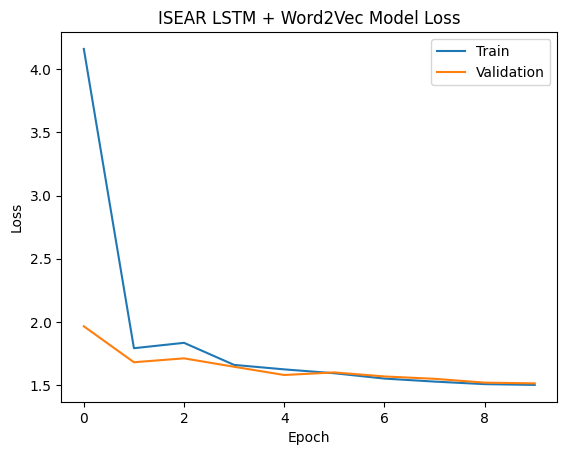

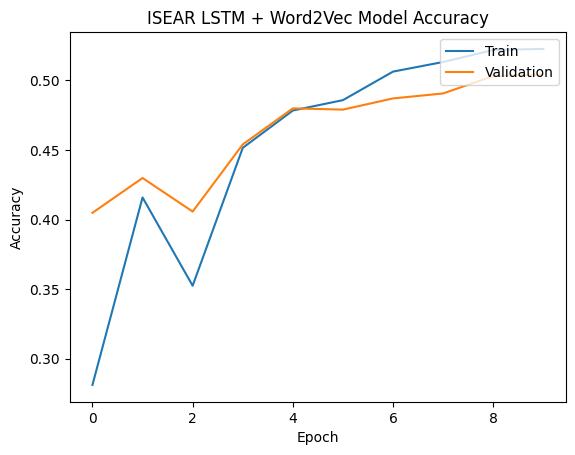

35/35 [==============================] - 1s 15ms/step - loss: 1.5076 - accuracy: 0.5188
Accuracy: 0.519%
Recall Score: 0.519
Precision: 0.553
F1 Score: 0.500
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 lstm_1 (LSTM)               (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                            

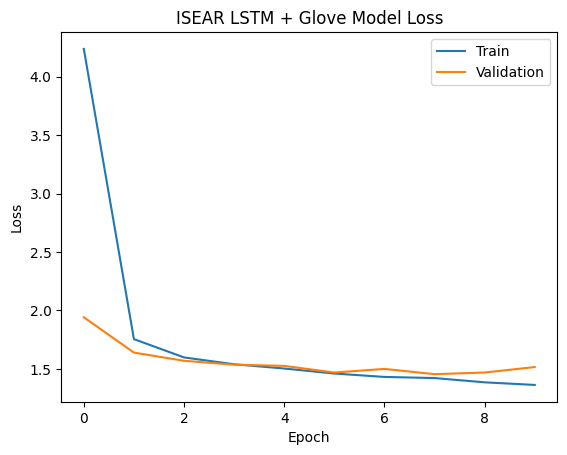

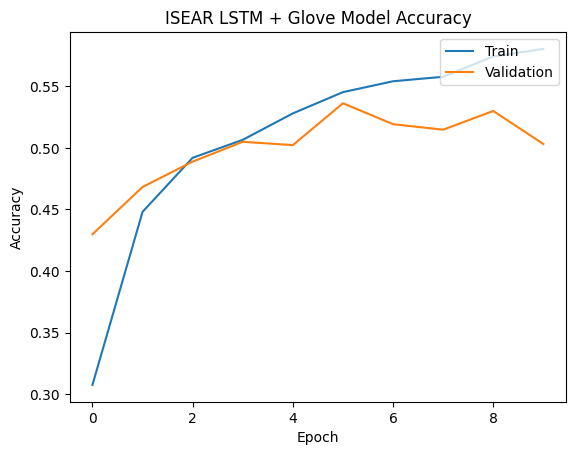

35/35 [==============================] - 0s 14ms/step - loss: 1.4813 - accuracy: 0.5072
Accuracy: 0.507%
Recall Score: 0.507
Precision: 0.544
F1 Score: 0.508
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 lstm_2 (LSTM)               (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                            

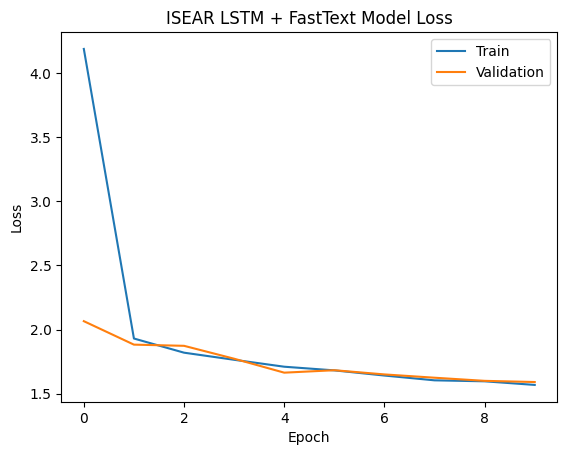

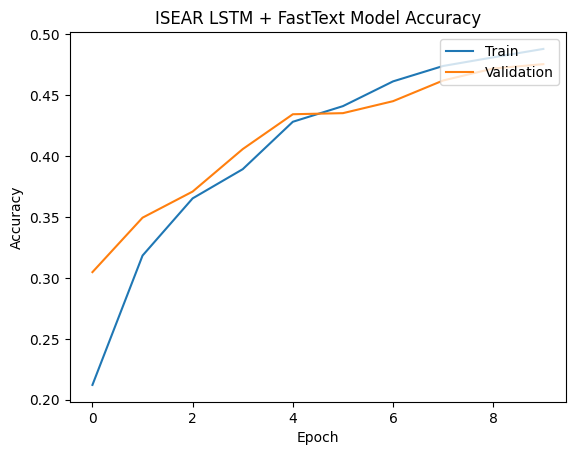

35/35 [==============================] - 0s 14ms/step - loss: 1.5657 - accuracy: 0.4973
Accuracy: 0.497%
Recall Score: 0.497
Precision: 0.527
F1 Score: 0.489
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 300)          3664500   
                                                                 
 lstm_3 (LSTM)               (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                            

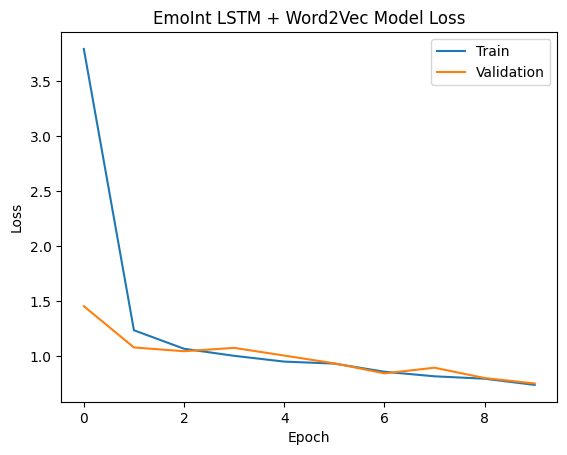

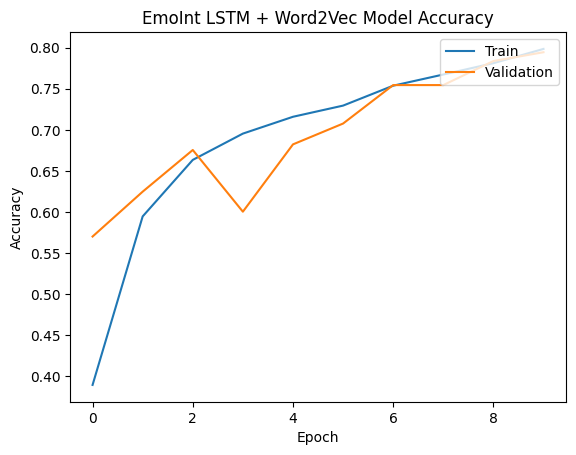

33/33 [==============================] - 0s 14ms/step - loss: 0.7593 - accuracy: 0.7934
Accuracy: 0.793%
Recall Score: 0.793
Precision: 0.798
F1 Score: 0.794
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 400, 300)          3664500   
                                                                 
 lstm_4 (LSTM)               (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                            

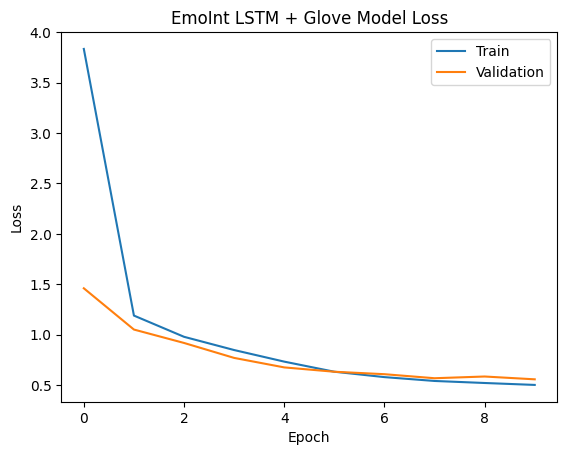

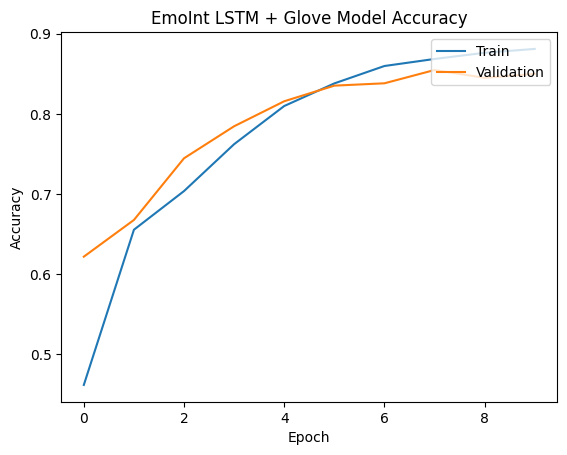

33/33 [==============================] - 0s 14ms/step - loss: 0.5554 - accuracy: 0.8694
Accuracy: 0.869%
Recall Score: 0.869
Precision: 0.872
F1 Score: 0.869
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 400, 300)          3664500   
                                                                 
 lstm_5 (LSTM)               (None, 400, 128)          219648    
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                            

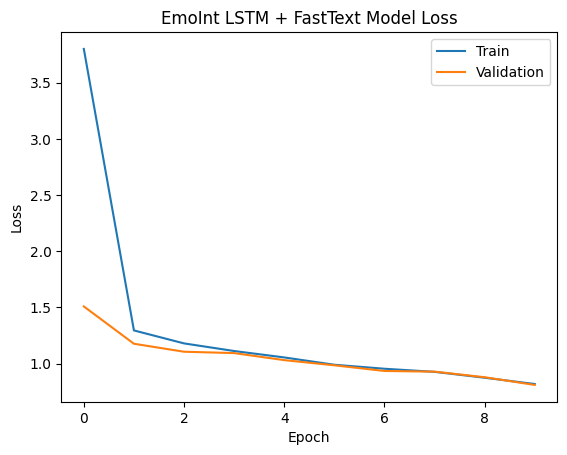

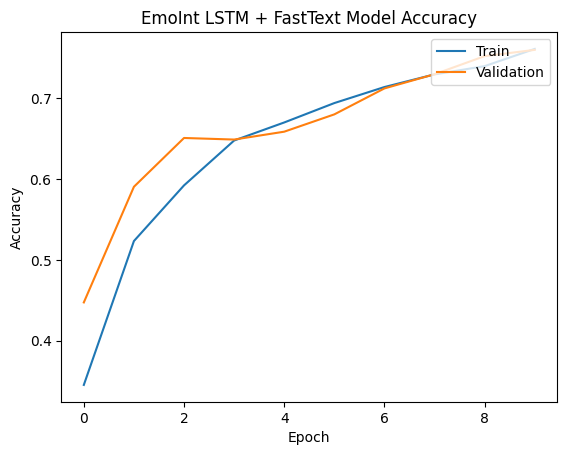

33/33 [==============================] - 1s 15ms/step - loss: 0.8209 - accuracy: 0.7544
Accuracy: 0.754%
Recall Score: 0.754
Precision: 0.766
F1 Score: 0.750


In [29]:
res_isear_lstm_word2vec = test_model("LSTM", "Word2Vec", "ISEAR")
res_isear_lstm_glove = test_model("LSTM", "Glove", "ISEAR")
res_isear_lstm_fasttext = test_model("LSTM", "FastText", "ISEAR")

res_emoint_lstm_word2vec = test_model("LSTM", "Word2Vec", "EmoInt")
res_emoint_lstm_glove = test_model("LSTM", "Glove", "EmoInt")
res_emoint_lstm_fasttext = test_model("LSTM", "FastText", "EmoInt")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         439296    
 l)                                                              
                                                                 
 global_max_pooling1d_6 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2,922,995
Trainable params: 441,095
Non-

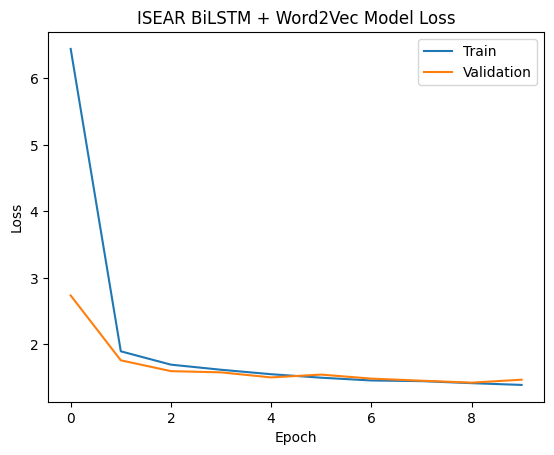

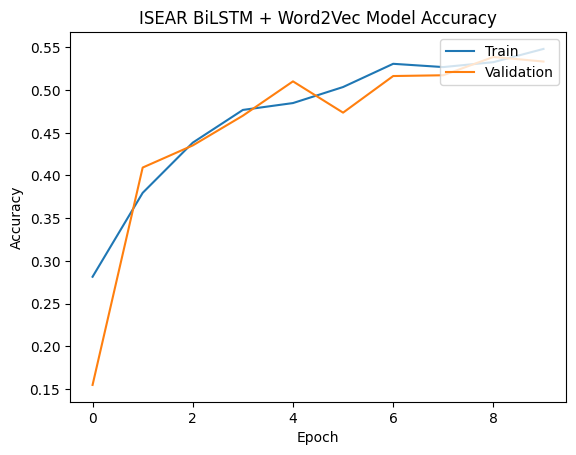

35/35 [==============================] - 1s 29ms/step - loss: 1.4426 - accuracy: 0.5286
Accuracy: 0.529%
Recall Score: 0.529
Precision: 0.544
F1 Score: 0.514
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 bidirectional_1 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_7 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)            

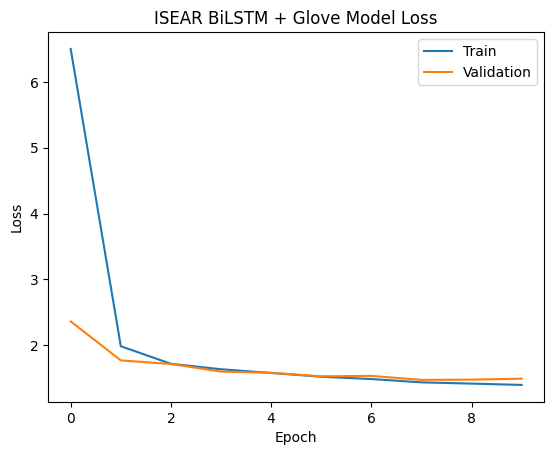

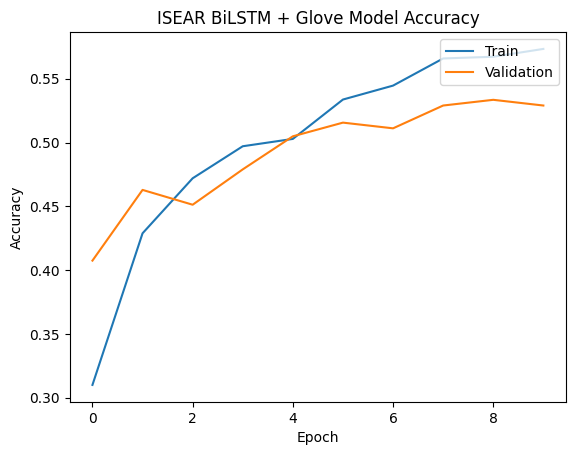

35/35 [==============================] - 1s 29ms/step - loss: 1.4781 - accuracy: 0.5313
Accuracy: 0.531%
Recall Score: 0.531
Precision: 0.548
F1 Score: 0.510
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)            

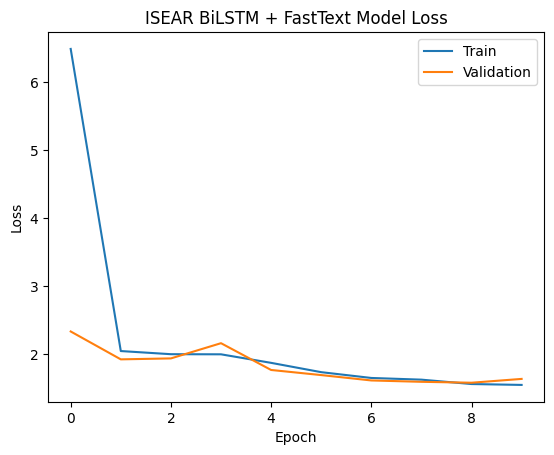

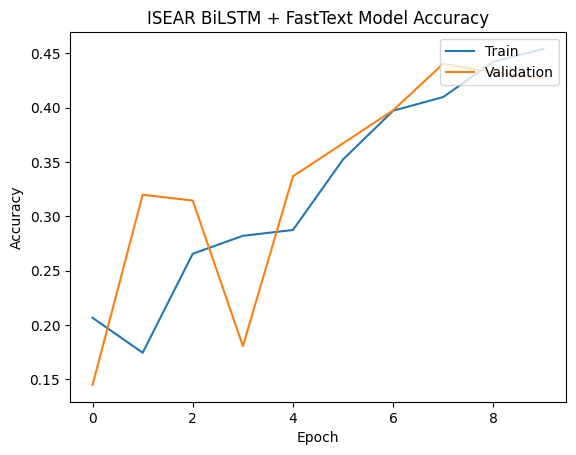

35/35 [==============================] - 1s 25ms/step - loss: 1.5756 - accuracy: 0.4383
Accuracy: 0.438%
Recall Score: 0.438
Precision: 0.506
F1 Score: 0.431
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 400, 300)          3664500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)            

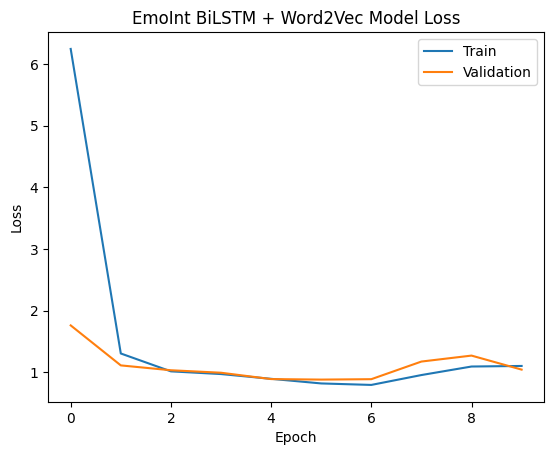

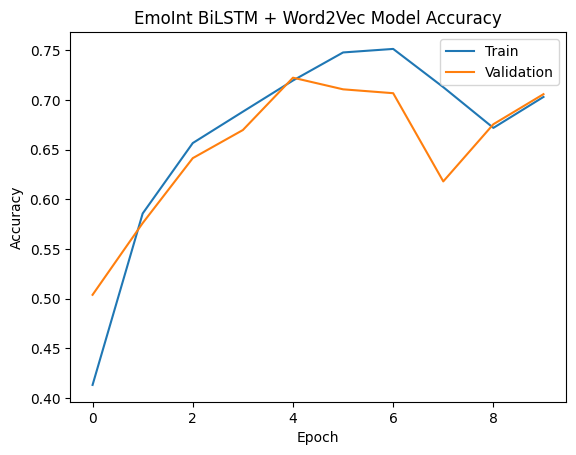

33/33 [==============================] - 1s 30ms/step - loss: 1.0478 - accuracy: 0.6949
Accuracy: 0.695%
Recall Score: 0.695
Precision: 0.701
F1 Score: 0.683
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_10 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)          

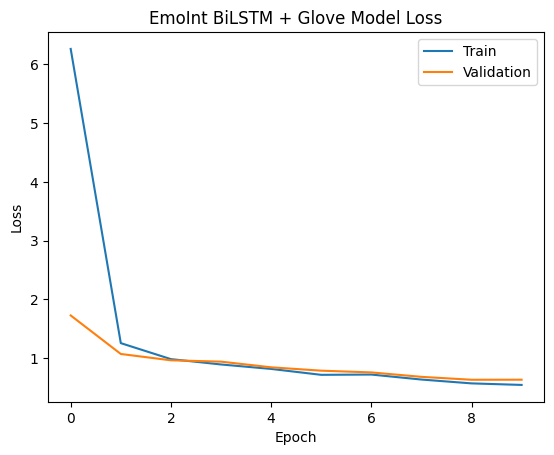

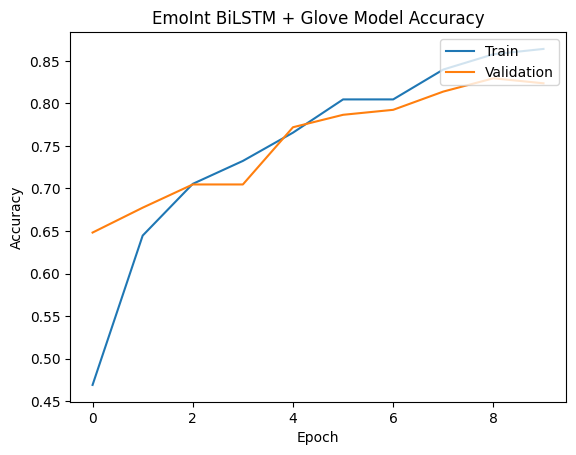

33/33 [==============================] - 1s 24ms/step - loss: 0.6193 - accuracy: 0.8499
Accuracy: 0.850%
Recall Score: 0.850
Precision: 0.853
F1 Score: 0.850
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 bidirectional_5 (Bidirectio  (None, 400, 256)         439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_11 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)          

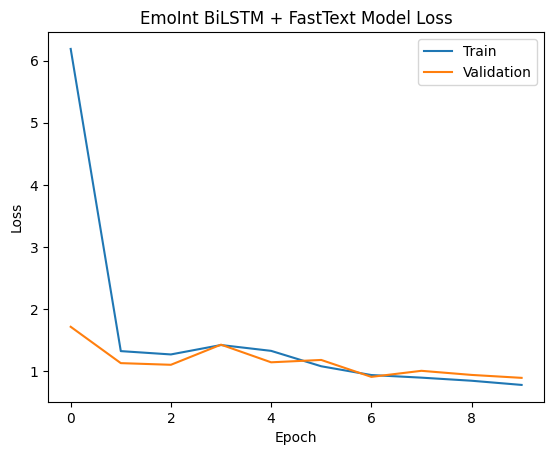

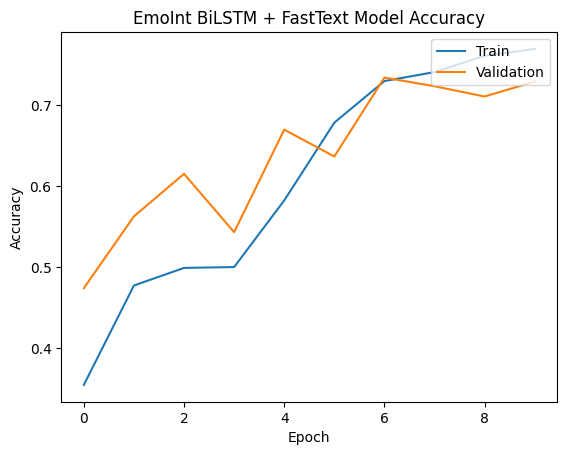

33/33 [==============================] - 1s 25ms/step - loss: 0.8571 - accuracy: 0.7290
Accuracy: 0.729%
Recall Score: 0.729
Precision: 0.760
F1 Score: 0.728


In [30]:
res_isear_bilstm_word2vec = test_model("BiLSTM", "Word2Vec", "ISEAR")
res_isear_bilstm_glove = test_model("BiLSTM", "Glove", "ISEAR")
res_isear_bilstm_fasttext = test_model("BiLSTM", "FastText", "ISEAR")

res_emoint_bilstm_word2vec = test_model("BiLSTM", "Word2Vec", "EmoInt")
res_emoint_bilstm_glove = test_model("BiLSTM", "Glove", "EmoInt")
res_emoint_bilstm_fasttext = test_model("BiLSTM", "FastText", "EmoInt")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 gru (GRU)                   (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_12 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 7)                 903       
                                                                 
Total params: 2,647,923
Trainable params: 166,023
Non-trainable params: 2,481,900
_____________________________________

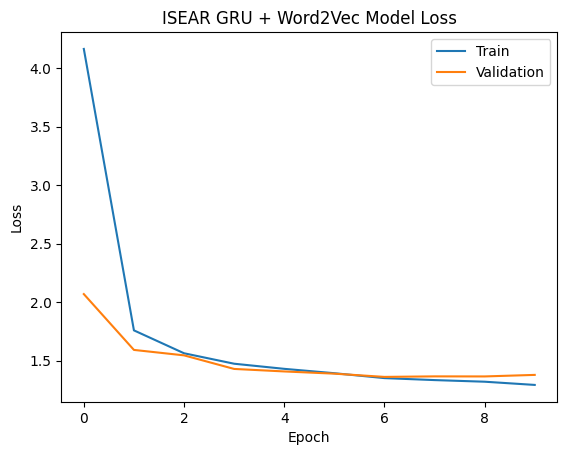

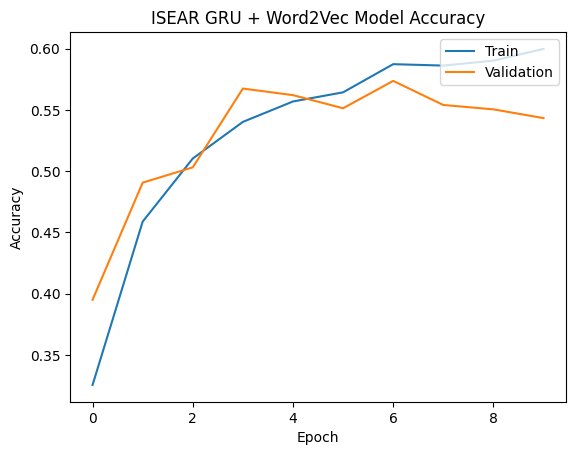

35/35 [==============================] - 1s 16ms/step - loss: 1.3968 - accuracy: 0.5519
Accuracy: 0.552%
Recall Score: 0.552
Precision: 0.620
F1 Score: 0.542
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 gru_1 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_13 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 903       
                           

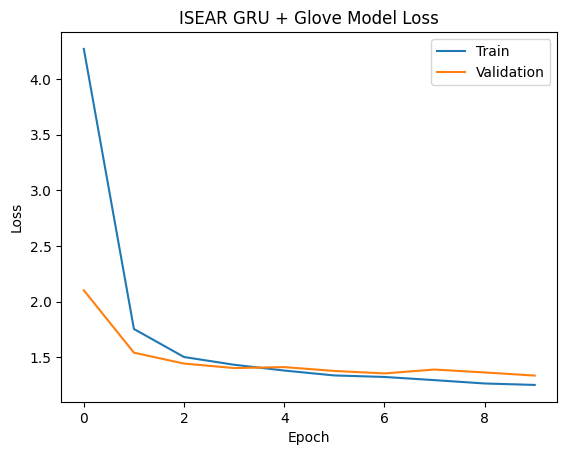

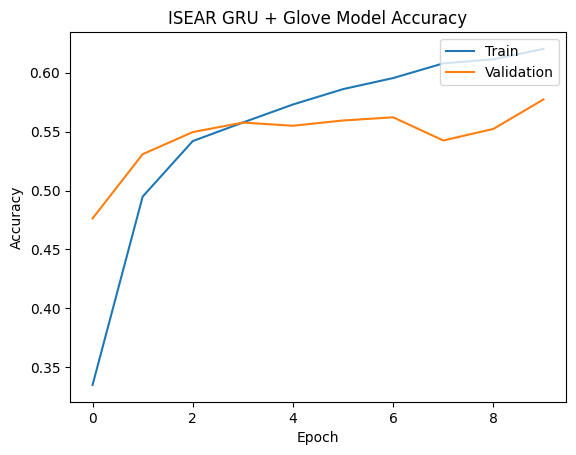

35/35 [==============================] - 1s 14ms/step - loss: 1.3335 - accuracy: 0.5751
Accuracy: 0.575%
Recall Score: 0.575
Precision: 0.580
F1 Score: 0.567
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 gru_2 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_14 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 7)                 903       
                           

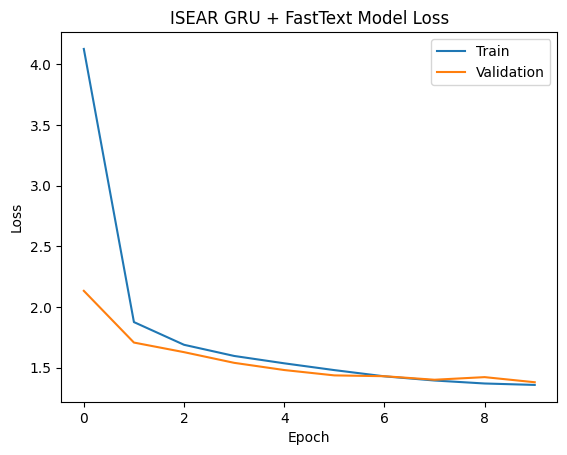

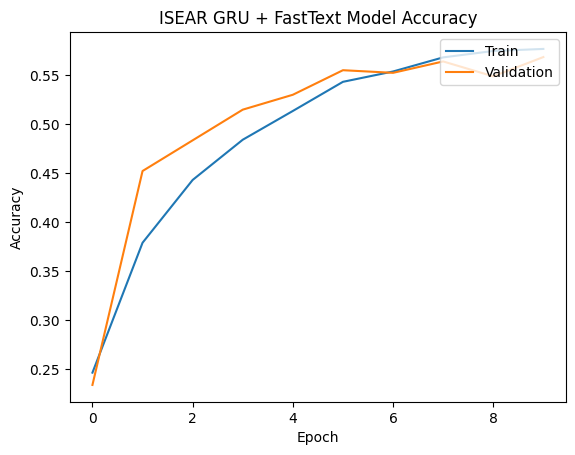

35/35 [==============================] - 0s 13ms/step - loss: 1.3833 - accuracy: 0.5635
Accuracy: 0.564%
Recall Score: 0.564
Precision: 0.589
F1 Score: 0.554
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 gru_3 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_15 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 516       
                           

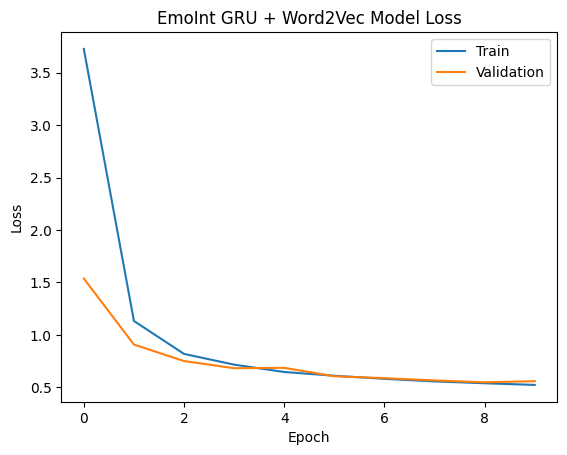

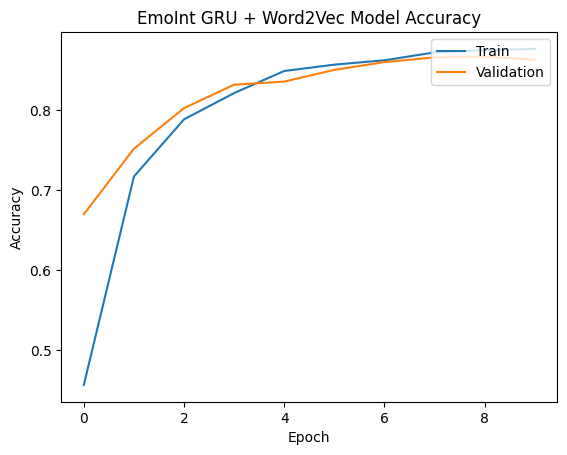

33/33 [==============================] - 1s 15ms/step - loss: 0.5615 - accuracy: 0.8635
Accuracy: 0.864%
Recall Score: 0.864
Precision: 0.864
F1 Score: 0.863
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 gru_4 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_16 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 4)                 516       
                           

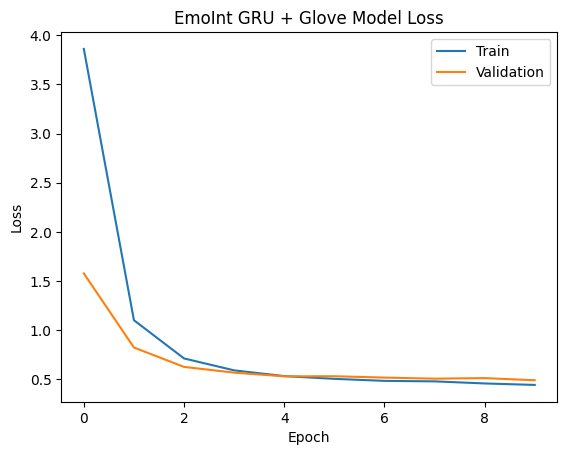

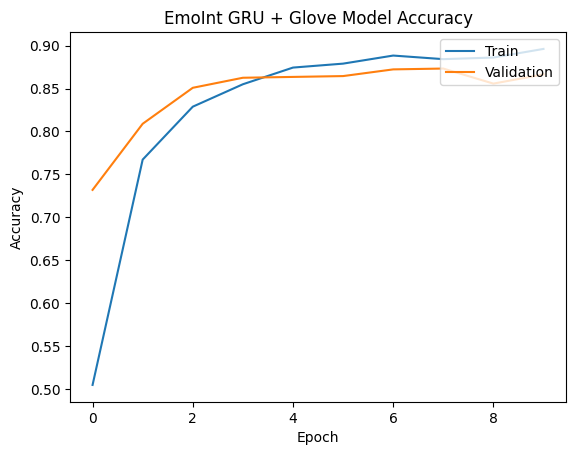

33/33 [==============================] - 0s 14ms/step - loss: 0.4956 - accuracy: 0.8772
Accuracy: 0.877%
Recall Score: 0.877
Precision: 0.878
F1 Score: 0.877
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 gru_5 (GRU)                 (None, 400, 128)          165120    
                                                                 
 global_max_pooling1d_17 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                 516       
                           

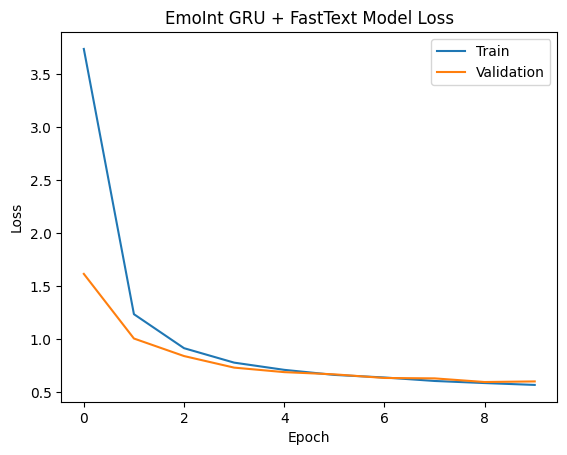

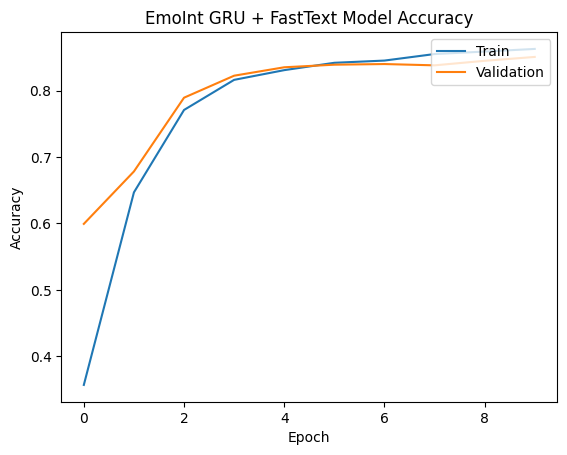

33/33 [==============================] - 0s 14ms/step - loss: 0.5933 - accuracy: 0.8606
Accuracy: 0.861%
Recall Score: 0.861
Precision: 0.865
F1 Score: 0.862


In [31]:
res_isear_gru_word2vec = test_model("GRU", "Word2Vec", "ISEAR")
res_isear_gru_glove = test_model("GRU", "Glove", "ISEAR")
res_isear_gru_fasttext = test_model("GRU", "FastText", "ISEAR")

res_emoint_gru_word2vec = test_model("GRU", "Word2Vec", "EmoInt")
res_emoint_gru_glove = test_model("GRU", "Glove", "EmoInt")
res_emoint_gru_fasttext = test_model("GRU", "FastText", "EmoInt")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 bidirectional_6 (Bidirectio  (None, 400, 256)         330240    
 nal)                                                            
                                                                 
 global_max_pooling1d_18 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 2,813,939
Trainable params: 332,039
Non

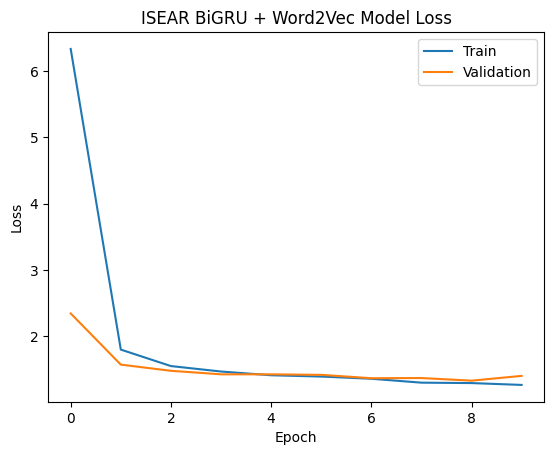

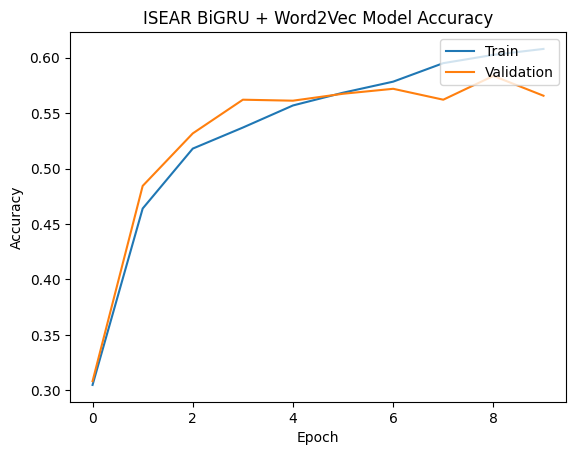

35/35 [==============================] - 1s 21ms/step - loss: 1.3772 - accuracy: 0.5707
Accuracy: 0.571%
Recall Score: 0.571
Precision: 0.600
F1 Score: 0.571
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 bidirectional_7 (Bidirectio  (None, 400, 256)         330240    
 nal)                                                            
                                                                 
 global_max_pooling1d_19 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)          

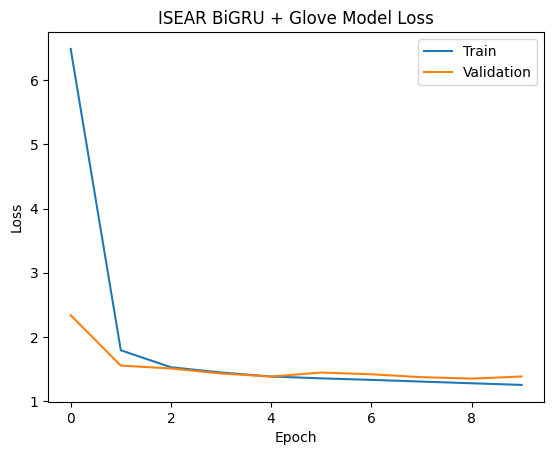

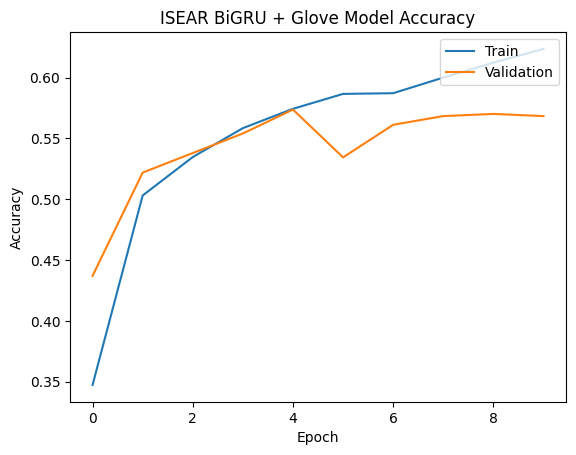

35/35 [==============================] - 1s 23ms/step - loss: 1.3774 - accuracy: 0.5572
Accuracy: 0.557%
Recall Score: 0.557
Precision: 0.578
F1 Score: 0.555
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 bidirectional_8 (Bidirectio  (None, 400, 256)         330240    
 nal)                                                            
                                                                 
 global_max_pooling1d_20 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)          

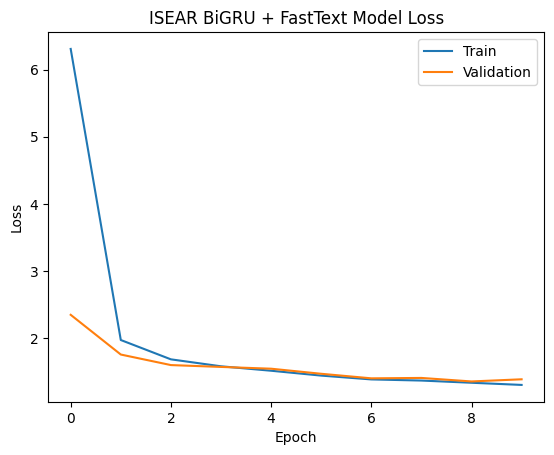

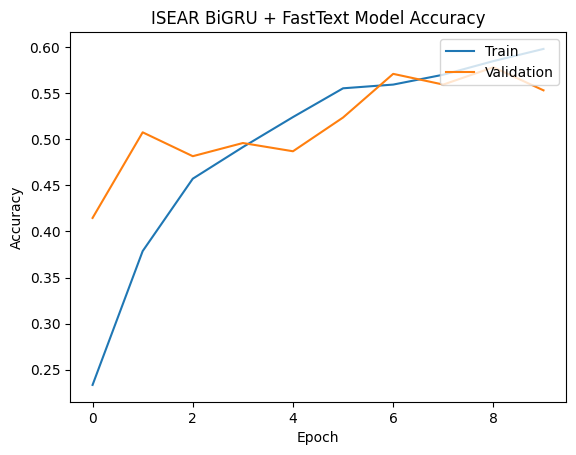

35/35 [==============================] - 1s 17ms/step - loss: 1.3759 - accuracy: 0.5519
Accuracy: 0.552%
Recall Score: 0.552
Precision: 0.594
F1 Score: 0.540
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 400, 256)         330240    
 nal)                                                            
                                                                 
 global_max_pooling1d_21 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)          

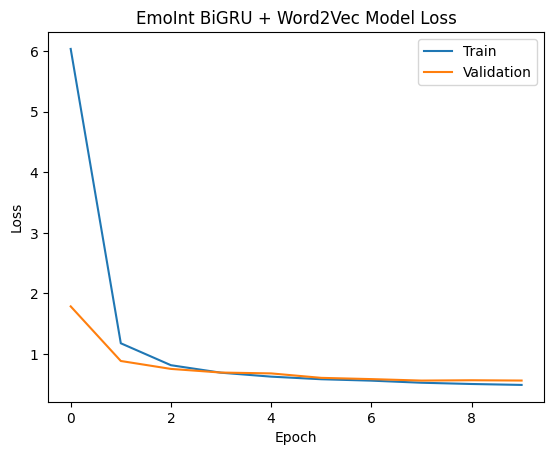

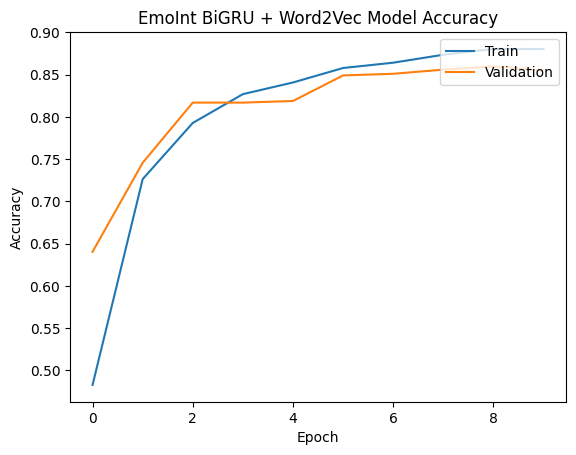

33/33 [==============================] - 1s 26ms/step - loss: 0.5442 - accuracy: 0.8645
Accuracy: 0.865%
Recall Score: 0.865
Precision: 0.866
F1 Score: 0.864
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 bidirectional_10 (Bidirecti  (None, 400, 256)         330240    
 onal)                                                           
                                                                 
 global_max_pooling1d_22 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)          

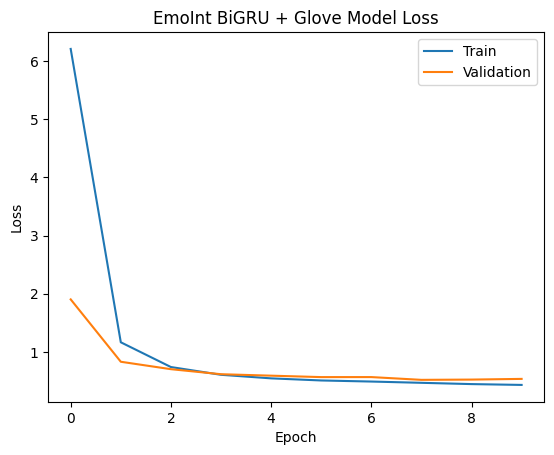

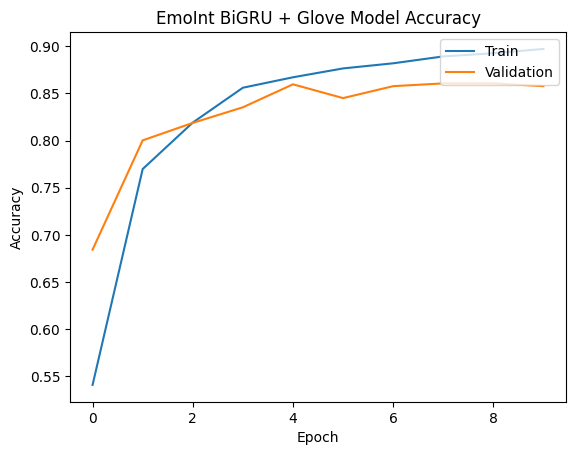

33/33 [==============================] - 1s 24ms/step - loss: 0.5436 - accuracy: 0.8606
Accuracy: 0.861%
Recall Score: 0.861
Precision: 0.863
F1 Score: 0.861
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 400, 300)          3664500   
                                                                 
 bidirectional_11 (Bidirecti  (None, 400, 256)         330240    
 onal)                                                           
                                                                 
 global_max_pooling1d_23 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)          

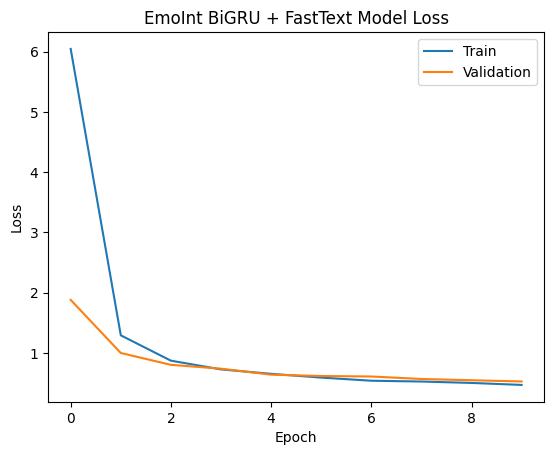

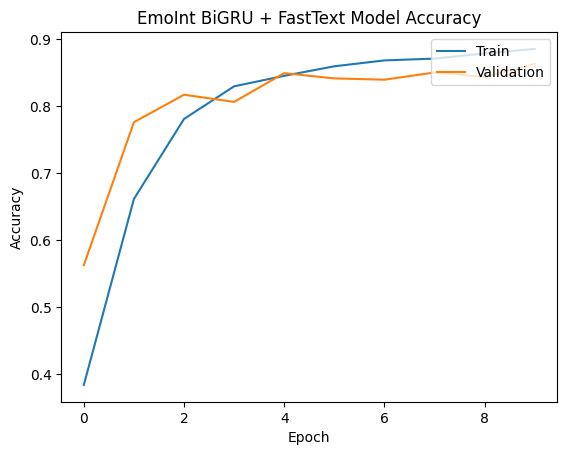

33/33 [==============================] - 1s 24ms/step - loss: 0.5061 - accuracy: 0.8743
Accuracy: 0.874%
Recall Score: 0.874
Precision: 0.877
F1 Score: 0.875


In [32]:
res_isear_bigru_word2vec = test_model("BiGRU", "Word2Vec", "ISEAR")
res_isear_bigru_glove = test_model("BiGRU", "Glove", "ISEAR")
res_isear_bigru_fasttext = test_model("BiGRU", "FastText", "ISEAR")

res_emoint_bigru_word2vec = test_model("BiGRU", "Word2Vec", "EmoInt")
res_emoint_bigru_glove = test_model("BiGRU", "Glove", "EmoInt")
res_emoint_bigru_fasttext = test_model("BiGRU", "FastText", "EmoInt")

In [33]:
import csv
from tabulate import tabulate

model_list = ["LSTM", "BiLSTM", "GRU", "BiGRU"]
embedding_list = ["Word2Vec", "Glove", "FastText"]
performance_list = ["Accuracy", "Recall", "Precision", "F1 Score"]
test_list_isear = [res_isear_lstm_word2vec, res_isear_lstm_glove, res_isear_lstm_fasttext, 
                   res_isear_bilstm_word2vec, res_isear_bilstm_glove, res_isear_bilstm_fasttext, 
                   res_isear_gru_word2vec, res_isear_gru_glove, res_isear_gru_fasttext, 
                   res_isear_bigru_word2vec, res_isear_bigru_glove, res_isear_bigru_fasttext]
test_list_emoint = [res_emoint_lstm_word2vec, res_emoint_lstm_glove, res_emoint_lstm_fasttext, 
                    res_emoint_bilstm_word2vec, res_emoint_bilstm_glove, res_emoint_bilstm_fasttext, 
                    res_emoint_gru_word2vec, res_emoint_gru_glove, res_emoint_gru_fasttext, 
                    res_emoint_bigru_word2vec, res_emoint_bigru_glove, res_emoint_bigru_fasttext]


results_isear = [["Model"] + performance_list]
results_emoint = [["Model"] + performance_list]

for model_key, model in enumerate(model_list):
    for embedding_key, embedding in enumerate(embedding_list):
        row_isear = [f"{model} + {embedding}"]
        row_emoint = [f"{model} + {embedding}"]
        row_isear.extend([round(test_list_isear[model_key * len(embedding_list) + embedding_key][metric], 4) for metric in performance_list])
        row_emoint.extend([round(test_list_emoint[model_key * len(embedding_list) + embedding_key][metric], 4) for metric in performance_list])

        results_isear.append(row_isear)
        results_emoint.append(row_emoint)

table_isear = tabulate(results_isear, headers="firstrow", tablefmt="fancy_grid")
table_emoint = tabulate(results_emoint, headers="firstrow", tablefmt="fancy_grid")


with open("./Output/ISEAR_results.csv", "w") as file:
    writer = csv.writer(file)
    writer.writerows(results_isear)

with open("./Output/EmoInt_results.csv", "w") as file:
    writer = csv.writer(file)
    writer.writerows(results_emoint)

In [34]:
print("ISEAR: ")
print(table_isear)

ISEAR: 
╒═══════════════════╤════════════╤══════════╤═════════════╤════════════╕
│ Model             │   Accuracy │   Recall │   Precision │   F1 Score │
╞═══════════════════╪════════════╪══════════╪═════════════╪════════════╡
│ LSTM + Word2Vec   │     0.5188 │   0.5188 │      0.5533 │     0.4997 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ LSTM + Glove      │     0.5072 │   0.5072 │      0.5435 │     0.5078 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ LSTM + FastText   │     0.4973 │   0.4973 │      0.5273 │     0.4887 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + Word2Vec │     0.5286 │   0.5286 │      0.5436 │     0.5142 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + Glove    │     0.5313 │   0.5313 │      0.5481 │     0.51   │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + FastText │     0.4383 │   0.4383

In [35]:
print("EmoInt: ")
print(table_emoint)

EmoInt: 
╒═══════════════════╤════════════╤══════════╤═════════════╤════════════╕
│ Model             │   Accuracy │   Recall │   Precision │   F1 Score │
╞═══════════════════╪════════════╪══════════╪═════════════╪════════════╡
│ LSTM + Word2Vec   │     0.7934 │   0.7934 │      0.7976 │     0.7941 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ LSTM + Glove      │     0.8694 │   0.8694 │      0.8724 │     0.8694 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ LSTM + FastText   │     0.7544 │   0.7544 │      0.7656 │     0.7498 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + Word2Vec │     0.6949 │   0.6949 │      0.701  │     0.6826 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + Glove    │     0.8499 │   0.8499 │      0.8527 │     0.8502 │
├───────────────────┼────────────┼──────────┼─────────────┼────────────┤
│ BiLSTM + FastText │     0.729  │   0.729